Exploracion de los datos proporcionados por yelp

1.0 importacion de librerias

In [ ]:
import pandas as pd
import warnings
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import os
import seaborn as sns


1.1 configuracion

In [ ]:
warnings.filterwarnings("ignore")


2. Carga de datos

In [10]:
business= pd.read_csv(r'C:\Users\ruizr\Desktop\datos\yelp\business.csv')

In [6]:
chunks = pd.read_json(r"C:\Users\ruizr\Desktop\datos\yelp\review.json", lines=True, chunksize=1000000)
review = pd.concat(chunks, ignore_index=True)

    

- *Exploracion de los datos*

In [12]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state.1,postal_code.1,latitude.1,longitude.1,stars.1,review_count.1,is_open.1,attributes.1,categories.1,hours.1
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


In [8]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 480.0+ MB


In [13]:
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

- *Se ha decidicido para el analisis utilizar la data desde el 01-01-2016*

In [49]:
review["date"] = pd.to_datetime(review["date"])
review_yelp= review[review["date"] >= "2016-01-01"]


In [50]:
review_yelp.shape

(4596987, 9)

- *Se eliminan los duplicados de review*

In [ ]:
duplicados = review.duplicated().sum()
print(f"Se encontraron {duplicados} filas duplicadas.")
review.drop_duplicates(inplace=True)
print(f"Duplicados eliminados. Nuevo tamaño del DataFrame: {review.shape}")

## Business

* Las columnas de business se encuentran repetidas con el mismo nombre mas un .1 al final, se procede a eliminarlas

In [14]:
business = business.loc[:, ~business.columns.str.endswith('.1')]

In [45]:
print(business.info())
print(business.isnull().sum())
duplicados = business[business.duplicated()]
print(f'duplicados : {len(duplicados)}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       145219 non-null  object 
 3   city          150346 non-null  object 
 4   state         150343 non-null  object 
 5   postal_code   150273 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB
None
business_id         0
name                0
address          5127
city                0
state               3
postal_

- Se filtran las filas que contengan en la columna categories la palabra fast food o similares

In [46]:
resto_business = business[business['categories'].apply(
    lambda x: any(re.search(r'fast food', c, re.IGNORECASE) for c in x.split(', ')) if isinstance(x, str) else False
)]
print(f"Se encontraron {len(resto_business)} filas con categorías que contienen 'fast food'.")

Se encontraron 6472 filas con categorías que contienen 'fast food'.


In [47]:
print(resto_business.shape)
print(resto_business.columns.tolist())
print(resto_business.isnull().sum())

(6472, 14)
['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']
business_id       0
name              0
address           5
city              0
state             0
postal_code       0
latitude          0
longitude         0
stars             0
review_count      0
is_open           0
attributes       34
categories        0
hours           492
dtype: int64


In [ ]:
resto_business["attributes"]

3         {'RestaurantsDelivery': 'False', 'OutdoorSeati...
29                          {'RestaurantsPriceRange2': '1'}
88        {'BusinessParking': "{'garage': False, 'street...
222       {'RestaurantsReservations': 'False', 'Restaura...
409       {'Alcohol': "u'none'", 'RestaurantsGoodForGrou...
                                ...                        
150165    {'OutdoorSeating': 'True', 'RestaurantsAttire'...
150172    {'Caters': 'False', 'RestaurantsPriceRange2': ...
150275    {'BusinessParking': "{'garage': False, 'street...
150287    {'GoodForKids': 'False', 'RestaurantsReservati...
150306    {'NoiseLevel': "u'average'", 'RestaurantsTakeO...
Name: attributes, Length: 1815, dtype: object

- Se seleccionan las filas que en la columna state sean CA ya que estas pertenecen a california

In [48]:
resto_business = resto_business[resto_business["state"].isin(["CA"])]
print(f"Se encontraron {len(resto_business)} registros con state en CA.")

Se encontraron 205 registros con state en CA.


- se cuentan y se eliminan los duplicados del df review

In [18]:
duplicados = review.duplicated().sum()
print(f"Se encontraron {duplicados} filas duplicadas.")
review.drop_duplicates(inplace=True)
print(f"Duplicados eliminados. Nuevo tamaño del DataFrame: {review.shape}")

Se encontraron 0 filas duplicadas.
Duplicados eliminados. Nuevo tamaño del DataFrame: (6990280, 9)


*Se eliminan aquellas columnas que no son relevantes para le analisis "is_open", "state"*

In [56]:
resto_business = resto_business.drop(columns=['state', 'is_open'])

## *Se concatenan los datos de review y business de yelp*
- para esto se utilizaran los df: review_yelp y el df resto_business

- Se filtra review_yelp as trves del business_id que se encuentra tambien en resto_business para obtener las reseñas solo de los fast food y se crea un nuevo df llamado review_ fastyelp


In [57]:
review_fastyelp = review_yelp.merge(resto_business,on="business_id",how="inner")


In [58]:
print(f"Dimensiones del DataFrame filtrado: {review_fastyelp.shape}")
print(review_fastyelp.head())

Dimensiones del DataFrame filtrado: (5246, 20)
                review_id                 user_id             business_id  \
0  DEDYyVHbVJ0IwfBiK2540w  6hu9jk0GMpgKN13fRLGNRQ  ruFtZKwlJASx5BTk1dh5AQ   
1  vejWPBLMsao1FaFuSpTk9Q  blxot4VryFDRFZDvXyMdDw  k9A4tAmei12tLprkrNPkcg   
2  sqDIAVZefupT8U36Heot-w  V7-EP1CbhjQeEq7f6ab3DQ  cLY7TxgdJCiGrD2C8DMEew   
3  5Bzkgd5ppjvreFPIW-BXTQ  T6cTV5Z7Z3QKX5ijV3IhQg  HlSve6o5TAXbl4UDwCfcFw   
4  P-9RErADwjWSEToLpfbVLA  GcdYgbaF75vj7RO6EZhPOQ  necnuacmR2jYCiEova3s-Q   

   stars_x  useful  funny  cool  \
0        2       0      0     0   
1        5       0      0     0   
2        1       0      0     0   
3        1       0      0     0   
4        4       5      4     5   

                                                text                date  \
0  Got there and lady's was not welcoming but neu... 2017-01-15 08:48:16   
1  I love this crazy chicken.  Probably the clean... 2016-08-13 02:14:09   
2  I typically love KFC but my opinion is changin..

In [59]:
print(review_fastyelp.isnull().sum())

review_id         0
user_id           0
business_id       0
stars_x           0
useful            0
funny             0
cool              0
text              0
date              0
name              0
address           0
city              0
postal_code       0
latitude          0
longitude         0
stars_y           0
review_count      0
attributes       12
categories        0
hours           185
dtype: int64


- el nuevo df ha reducido el df review_yelp a 5249 filas, es una reduccion significativa.
- ahora en review_restoyelp se encuentran las review solo para los fastfood que teniamos en resto_ business

In [62]:
review_fastyelp.head(2)

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,address,city,postal_code,latitude,longitude,stars_y,review_count,attributes,categories,hours
0,DEDYyVHbVJ0IwfBiK2540w,6hu9jk0GMpgKN13fRLGNRQ,ruFtZKwlJASx5BTk1dh5AQ,2,0,0,0,Got there and lady's was not welcoming but neu...,2017-01-15 08:48:16,Wendy's,440 N Mccarran Blvd,Sparks,89431,39.538055,-119.734624,2.5,35,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Fast Food, Restaurants, Hot Dogs, Burgers","{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W..."
1,vejWPBLMsao1FaFuSpTk9Q,blxot4VryFDRFZDvXyMdDw,k9A4tAmei12tLprkrNPkcg,5,0,0,0,I love this crazy chicken. Probably the clean...,2016-08-13 02:14:09,El Pollo Loco,10320 N Mccarran Blvd,Reno,89503,39.532104,-119.864028,3.5,54,"{'Alcohol': ""u'none'"", 'RestaurantsPriceRange2...","Fast Food, Restaurants, Mexican","{'Monday': '0:0-0:0', 'Tuesday': '10:0-22:0', ..."


- *Restorants, fast food en california*

In [65]:
fastfood_uniq = review_fastyelp['name'].unique().tolist()
print(f"Total de nombres únicos de negocios: {len(fastfood_uniq)}")


Total de nombres únicos de negocios: 76


In [64]:
fastfood_uniq

["Wendy's",
 'El Pollo Loco',
 'KFC',
 'Sonic Drive-In',
 'Taco Bell',
 "eegee's",
 'Panda Express',
 "McDonald's",
 'Pizza Hut',
 "Jerry's Rotisserie and Fried Chicken",
 'Quiznos',
 'Subway',
 'A&W',
 "Zaxby's Chicken Fingers & Buffalo Wings",
 "Arby's",
 'Burger King',
 'Taco Del Mar',
 'QDOBA Mexican Eats',
 'Bon Bon Sushi',
 'Chipotle Mexican Grill',
 "Jimmy John's",
 'White Castle',
 'Flame Broiler',
 'Five Guys',
 'Classic K Hamburgers',
 "Rally's",
 'Checkers',
 'Gyro Shack',
 'QuikTrip',
 "Culver's",
 'Popeyes Louisiana Kitchen',
 'Sparks and Smoke BBQ',
 'Chick-fil-A',
 'G&G Pizza Eatery',
 "Hardee's",
 'Firehouse Subs',
 'Fat Mos',
 'Extreme Pita',
 'Popeyes Lousiana Kitchen',
 "Freddy's Frozen Custard & Steakburgers",
 'MOD Pizza',
 'In-N-Out Burger',
 'Steak ’n Shake',
 'Patio 6 Prime Smokehouse Wing Bar and Grill',
 "Jersey Mike's Subs",
 'Lucky Wishbone',
 "Carl's Jr.",
 'Dairy Queen Grill & Chill',
 'Potbelly Sandwich Shop',
 'Lung Wah Restaurant',
 "Uncle Tomy's",
 "Ra

-Se procede a explorar la cantidad de reseña de los restaurant

In [67]:
top10_business = review_fastyelp['name'].value_counts().head(10)
print(top10_business)


name
McDonald's                   493
Sparks and Smoke BBQ         475
Chick-fil-A                  341
Taco Bell                    230
Shake Shack                  213
Chipotle Mexican Grill       195
Popeyes Louisiana Kitchen    174
Burger King                  171
PDQ Cherry Hill              169
Subway                       163
Name: count, dtype: int64


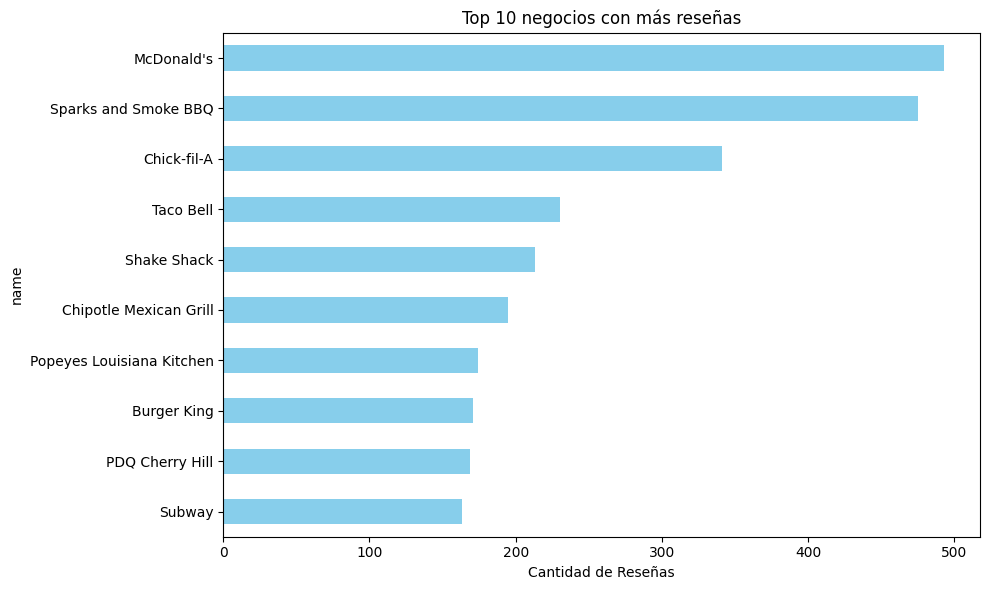

In [ ]:
top10_business.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.xlabel("Cantidad de Reseñas")
plt.title("Top 10 negocios con más reseñas")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## - *Top 10 fastfood mejor puntuados*

- *Si nos basamos en la cantidad de reseñas que hicieron los usuarios y el puntaje con el que calificaron podemos sacar un estimativo de los locales mas reseñado.*
- *Por otro lado tambien contamos con el promedio de estrellas de cada local,se compararan ambos*

In [72]:

conteo = review_fastyelp['name'].value_counts()
nombres_validos = conteo[conteo >= 20].index #se coloca un minimo de 20 reseñas para ajustar la dispersion de los datos finales

promedios_filtrados = review_fastyelp[review_fastyelp['name'].isin(nombres_validos)].groupby('name')['stars_x'].mean()
top10_xreseñas = promedios_filtrados.sort_values(ascending=False).head(10)


In [73]:
top10_xreseñas

name
Sparks and Smoke BBQ        4.749474
Bon Bon Sushi               4.706522
MOD Pizza                   4.564103
Flame Broiler               4.024390
G&G Pizza Eatery            3.956522
Culver's                    3.953125
Little Greek Fresh Grill    3.920455
DiMeo's Pizza               3.912500
In-N-Out Burger             3.895522
Gyro Shack                  3.793103
Name: stars_x, dtype: float64

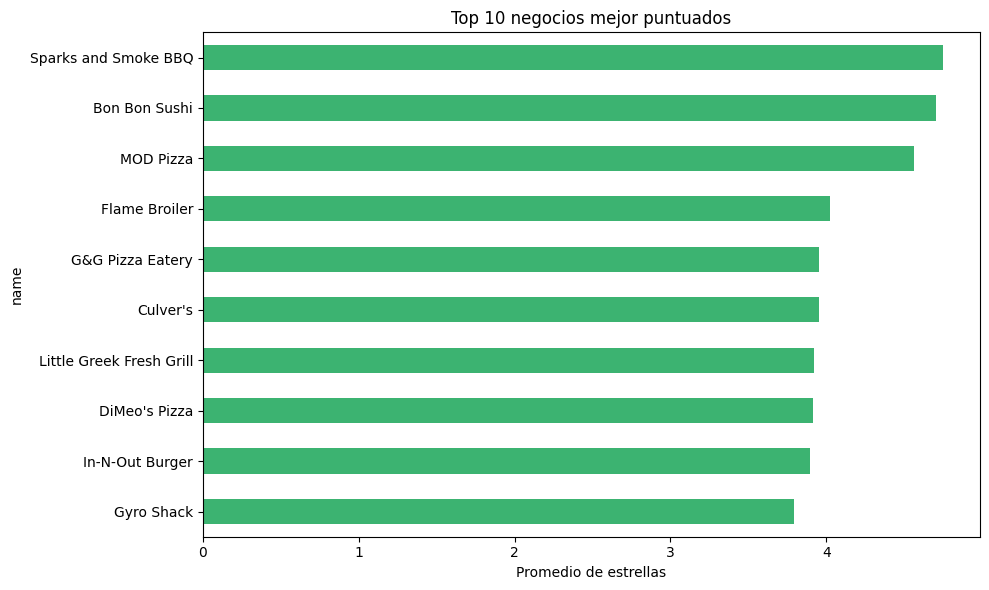

In [74]:
import matplotlib.pyplot as plt

top10_xreseñas.plot(kind='barh', color='mediumseagreen', figsize=(10,6))
plt.xlabel("Promedio de estrellas")
plt.title("Top 10 negocios mejor puntuados")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [75]:
top_rating = review_fastyelp[['name', 'stars_y']].drop_duplicates().sort_values(by='stars_y', ascending=False).head(10)
print(top_rating)


                        name  stars_y
349            Bon Bon Sushi      4.5
880     Sparks and Smoke BBQ      4.5
1962               MOD Pizza      4.5
893              Chick-fil-A      4.5
3511           Lion's Choice      4.5
3533  Charleys Philly Steaks      4.5
4715                  Subway      4.5
380               Gyro Shack      4.0
466                 QuikTrip      4.0
373     Classic K Hamburgers      4.0


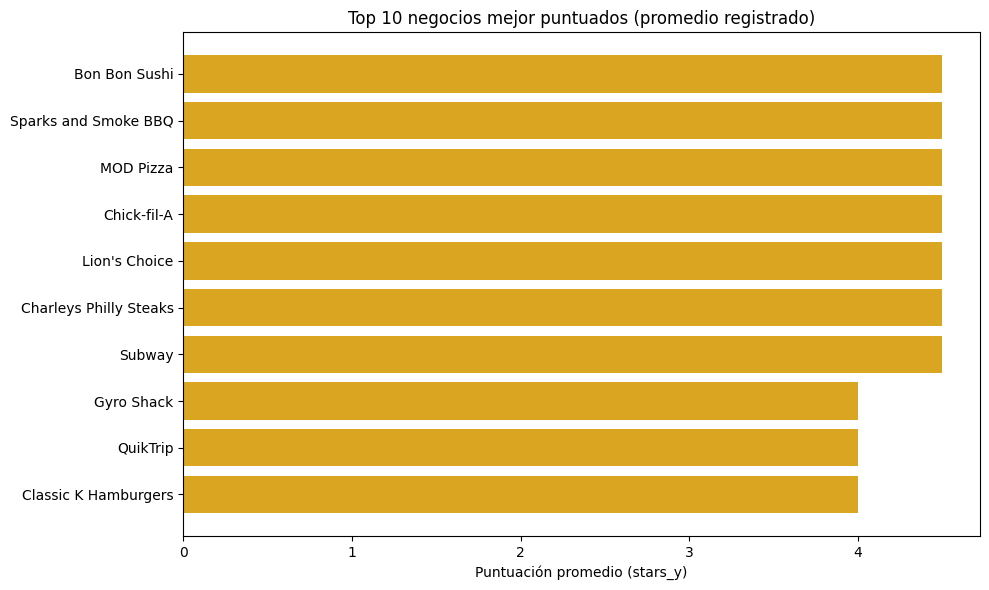

In [76]:
plt.figure(figsize=(10,6))
plt.barh(top_rating['name'], top_rating['stars_y'], color='goldenrod')
plt.xlabel("Puntuación promedio (stars_y)")
plt.title("Top 10 negocios mejor puntuados (promedio registrado)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


- *Se encontraron diferencias entre la puntuacion del local y la puntuacion que conceguimos analizando manualmente el promedio de las reseñas de los usuarios. podemos asumir que quizas es por la seleccion que hicimos de los datos.*

*A continuacion una nube de palabras para detectar cuales son aquellas que los usuarios estan utilizando mas en sus reseñas*

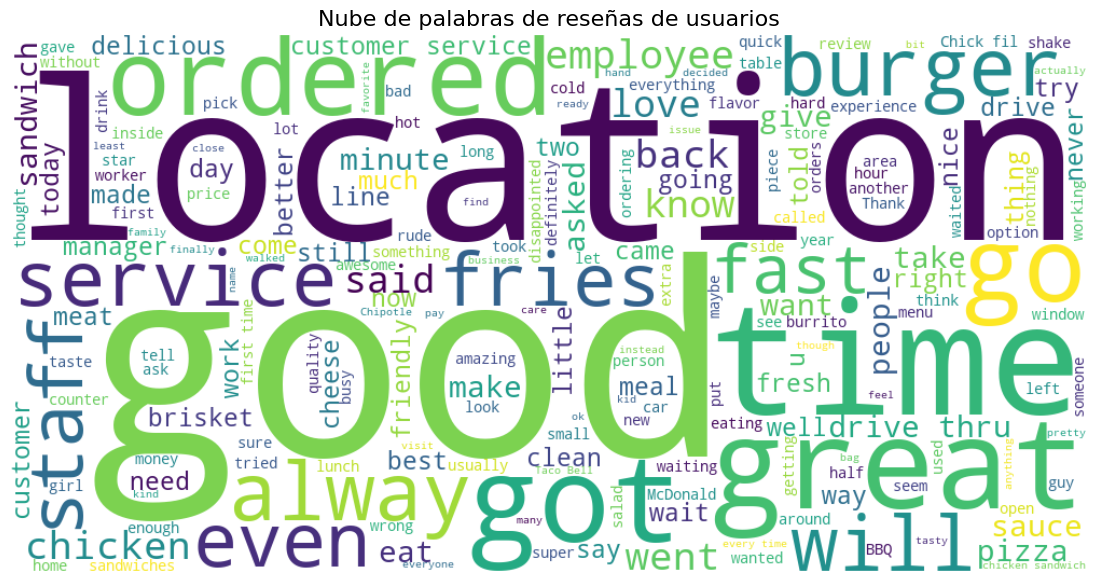

In [82]:
# Se unen todos los textos de las reseñas en un solo string
texto_total = " ".join(review_fastyelp['text'].astype(str).tolist())

stopwords = set(STOPWORDS)
stopwords.update(["restaurant", "food", "place", "one", "really", "like","fast food","order"])

wordcloud = WordCloud(width=1000, height=500, background_color='white', stopwords=stopwords).generate(texto_total)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras de reseñas de usuarios", fontsize=16)
plt.show()


- *Podemos distinguir que la palabra location distingue por encima de otras. es un buen indicador para el analisis futuro*